# Compute WBGT regional averages for the satellite plots

In [1]:
import regionmask
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import json
import glob

### Minimum number of days with snow to be considered in the mask

In [2]:
ndays = '14'

### Import the CliMAF library to do the pretreatments (https://climaf.readthedocs.io/en/master/)

In [3]:
from climaf.api import *

CliMAF version = 1.2.13


CliMAF install => /ciclad-home/jservon/Evaluation/CliMAF/climaf_installs/climaf_V1.2.13_post
python => /modfs/modtools/miniconda2/envs/analyse_2.7_v2/bin/python
---
Required softwares to run CliMAF => you are using the following versions/installations:
ncl 6.6.2 => /modfs/modtools/miniconda2/envs/analyse_2.7_v2/bin/ncl
cdo 1.9.6 => /opt/nco/1.9/bin/cdo
nco (ncks) 4.5.2 => /opt/nco-4.5.2/bin/ncks
ncdump fichier => /modfs/modtools/miniconda2/envs/analyse_2.7_v2/bin/ncdump
Check stamping requirements
nco (ncatted) found -> /opt/nco-4.5.2/bin/ncatted
convert found -> /usr/bin/convert
pdftk found -> /usr/bin/pdftk
exiv2 found -> /ciclad-home/jservon/Evaluation/CliMAF/climaf_installs/climaf_V1.2.13_post/bin/exiv2
---


Cache directory set to : /data/jservon/climafcache (use $CLIMAF_CACHE if set) 
Cache directory for remote data set to : /data/jservon/climafcache/remote_data (use $CLIMAF_REMOTE_CACHE if set) 
Available macros read from ~/.climaf.macros are : []


### Declare CliMAF project to get the data

In [4]:
pattern = '/data/ciles/IPCC/FGD/snow/final/cmip6/time_periods/${model}_${experiment}_snw100seas_${clim_period}_MEAN.1deg.nc'
cproject('snw_cmip6_ch12','experiment',('period','fx'), 'model', 'clim_period', ('variable','snw'), ensemble=['model'], separator='%')
dataloc(project='snw_cmip6_ch12', url=pattern)
pattern_gwl = '/data/ciles/IPCC/FGD/snow/final/cmip6/GWLs/${model}_${GWL}.nc'
cproject('snw_cmip6_GWL_ch12','model',('period','fx'),'GWL',('variable','snw'), ensemble=['model'], separator='%')
dataloc(project='snw_cmip6_GWL_ch12', url=pattern_gwl)

<climaf.dataloc.dataloc instance at 0x2b4b3c11f710>

In [5]:
# -- CMIP5
pattern = '/data/ciles/IPCC/FGD/snow/final/cmip5/time_periods/${model}_${experiment}_snw100seas_${clim_period}_MEAN.2deg.nc'
cproject('snw_cmip5_ch12','experiment',('period','fx'), 'model', 'clim_period', ('variable','snw'), ensemble=['model'], separator='%')
dataloc(project='snw_cmip5_ch12', url=pattern)
pattern_gwl = '/data/ciles/IPCC/FGD/snow/final/cmip5/GWLs/${model}_${GWL}.nc'
cproject('snw_cmip5_GWL_ch12','model',('period','fx'),'GWL',('variable','snw'), ensemble=['model'], separator='%')
dataloc(project='snw_cmip5_GWL_ch12', url=pattern_gwl)

<climaf.dataloc.dataloc instance at 0x2b4b3d3fa2d8>

In [6]:
# -- CORDEX
pattern = '/data/ciles/IPCC/FGD/snow/final/NA_CORDEX/time_periods/NAM-22_${model}_${experiment}_snw100seas_${clim_period}_remo22grid.nc'
cproject('snw_NAM-22_cordex_ch12','experiment',('period','fx'),'clim_period','model','thres', ('variable','snw'), ensemble=['model'], separator='%')
dataloc(project='snw_NAM-22_cordex_ch12', url=pattern) 
pattern_gwl = '/data/ciles/IPCC/FGD/snow/final/NA_CORDEX/GWLs/NAM-22_${model}_GWL${GWL}_snw100seas_remo22grid.nc'
cproject('snw_NAM-22_cordex_GWL_ch12',('period','fx'),'model','GWL', ('variable','snw'), ensemble=['model'], separator='%')
dataloc(project='snw_NAM-22_cordex_GWL_ch12', url=pattern_gwl)

<climaf.dataloc.dataloc instance at 0x2b4b3d459128>

In [19]:
def weighted_mean(da, weights, dim):
    """Reduce da by a weighted mean along some dimension(s).

    Parameters
    ----------
    da : DataArray
        Object over which the weighted reduction operation is applied.    
    weights : DataArray
        An array of weights associated with the values in this Dataset.
    dim : str or sequence of str, optional
        Dimension(s) over which to apply the weighted `mean`.
        
    Returns
    -------
    weighted_mean : DataArray
        New DataArray with weighted mean applied to its data and
        the indicated dimension(s) removed.
    """

    weighted_sum = (da * weights).sum(dim=dim, skipna=True)
    # need to mask weights where data is not valid
    masked_weights = weights.where(da.notnull())
    sum_of_weights = masked_weights.sum(dim=dim, skipna=True)
    valid_weights = sum_of_weights != 0
    sum_of_weights = sum_of_weights.where(valid_weights)

    return weighted_sum / sum_of_weights

def average_over_AR6_region_back(filename, mask_sup30, variable, region_name):

    # -- AR6 regions
    # -- Get the regions
    ar6_land = regionmask.defined_regions.ar6.land

    # -- Get land/sea mask (generic)
    land_110 = regionmask.defined_regions.natural_earth.land_110

    # -- Get data
    ds = xr.open_dataset(filename, decode_times=False)
    dat = ds[variable]
    dat.values = np.array(dat.values, dtype=np.float32)

    # -- Get the mask of values > 30
    mask_ds = xr.open_dataset(mask_sup30, decode_times=False)
    mask = mask_ds[variable]
    mask.values = np.array(mask.values, dtype=np.float32)
    #
    # -- Mask the data
    dat.values = dat.values * mask.values

    # -- Mask the data
    mask_3D = ar6_land.mask_3D(dat) # AR6 mask
    land_mask = land_110.mask_3D(dat) # Land sea mask
    mask_lsm = mask_3D * land_mask.squeeze(drop=True) # Combine the two

    weights = np.cos(np.deg2rad(dat.lat))
    
    if region_name=='all':
        return weighted_mean(dat, mask_3D * weights, ("lon", "lat"))
    else:
        if isinstance(region_name, list):
            res = list()
            for region in region_name:
                region_mask = mask_lsm.isel(region=list(mask_3D.abbrevs).index(region))
                dat_region = dat.where(region_mask)
                weights_region = weights.where(region_mask)
                res.append( weighted_mean(dat_region, region_mask*weights_region, ("lon","lat")) )
            return res
        else:
            region_mask = mask_lsm.isel(region=list(mask_3D.abbrevs).index(region_name))
            dat_region = dat.where(region_mask)
            weights_region = weights.where(region_mask) 
            return weighted_mean(dat_region, region_mask*weights_region, ("lon","lat"))
    
#
def average_over_AR6_region(filename, mask_sup30, variable, region_name):

    # -- AR6 regions
    #ar6_all = regionmask.defined_regions.ar6.all
    # -- Get the regions
    ar6_land = regionmask.defined_regions.ar6.land

    #ax = ar6_all.plot()
    # -- Get land/sea mask (generic)
    land_110 = regionmask.defined_regions.natural_earth.land_110

    # -- Get data
    ds = xr.open_dataset(filename, decode_times=False)
    dat = ds[variable]
    dat.values = np.array(dat.values, dtype=np.float32)

    # -- Get the mask of values > 30
    mask_ds = xr.open_dataset(mask_sup30, decode_times=False)
    mask = mask_ds[variable]
    mask.values = np.array(mask.values, dtype=np.float32)
    #
    # -- Mask the data
    dat.values = dat.values * mask.values

    # -- Mask the data
    mask_3D = ar6_land.mask_3D(dat) # AR6 mask
    land_mask = land_110.mask_3D(dat) # Land sea mask
    mask_lsm = mask_3D * land_mask.squeeze(drop=True) # Combine the two
    
    # -- Compute weights
    if dat.lat.shape == dat.shape:
        weights = np.cos(np.deg2rad(dat.lat))
    else:
        # -- Case dat is has time dim
        if 'time' in dat.dims:
            matlat = np.mean(dat.values, axis=dat.dims.index('time')) * 0
        else:
            matlat = dat.values * 0

        if dat.dims.index('lat')<dat.dims.index('lon'):
            for i in range(0,dat.shape[dat.dims.index('lon')]):
                matlat[:,i] = dat.lat
        else:
            for i in range(0,dat.shape[dat.dims.index('lon')]):
                matlat[i,:] = dat.lat
    
        weights = np.cos(np.deg2rad(matlat))
    
    if region_name=='all':
        return weighted_mean(dat, mask_3D * weights, ("lon", "lat"))
    else:
        if isinstance(region_name, list):
            res = list()
            for region in region_name:
                region_mask = mask_lsm.isel(region=list(mask_3D.abbrevs).index(region))
                dat_region = dat.where(region_mask)
                weights_region = np.where(region_mask, weights, float("nan"))
                #weights_region = weights.where(region_mask)
                res.append( weighted_mean(dat_region, region_mask*weights_region, ("lon","lat")) )
            return res
        else:
            region_mask = mask_lsm.isel(region=list(mask_3D.abbrevs).index(region_name))
            dat_region = dat.where(region_mask)
            weights_region = np.where(region_mask, weights, float("nan"))
            #weights_region = weights.where(region_mask)            
            return weighted_mean(dat_region, region_mask*weights_region, ("lon","lat"))
#
def regions_contained(lon, lat, regions):

    # determine if the longitude needs to be wrapped
    regions_is_180 = regions.lon_180
    grid_is_180 = regionmask.core.utils._is_180(lon.min(), lon.max())

    wrap_lon = not regions_is_180 == grid_is_180

    lon_orig = lon.copy()
    if wrap_lon:
        lon = regionmask.core.utils._wrapAngle(lon, wrap_lon)

    lon = np.asarray(lon).squeeze()
    lat = np.asarray(lat).squeeze()

    if lon.ndim == 1 and lat.ndim == 1:
        poly = shapely.geometry.box(lon.min(), lat.min(), lon.max(), lat.max())

    else:
        raise ValueError("Cannot currently handle 2D coordinates")

    fully_contained = list()
    for region_poly in regions.polygons:
        res = poly.contains(region_poly)

        fully_contained.append(res)

    return xr.DataArray(
        fully_contained, dims=["region"], coords=dict(region=regions.numbers)
    )

if None:
    region_name = "all"
    variable = 'tx35'
    filename = "/data/jservon/IPCC/tx35/individual_models/CMIP6_ssp585_tx35_2100_NorESM2-LM_r1i1p1f1.nc"

    tmp = average_over_AR6_region(filename, variable, region_name)
    tmp

### Start with baseline, mid-term, late-term, ssp126 and ssp585

In [8]:
# -- Make a mask using baseline to keep all the grid point that have at least ndays > 0
# -- appliquer le mask

In [9]:
exp_list = [
    # -- Baseline (ssp126 and ssp585 are the same files)
    dict(experiment='85',
         clim_period = '1995_2014'),    
    # -- Mid term
    dict(experiment='85',
         clim_period = '2041_2060'),
    dict(experiment='26',
         clim_period = '2041_2060'),
    # -- Late term
    dict(experiment='85',
         clim_period = '2081_2099'),
    dict(experiment='26',
         clim_period = '2081_2099'),
]

# -- Loop on the scenarios
ens_exp_dict = dict()
for exp in exp_list:
    #
    # -- Experiment and period
    experiment = exp['experiment']
    clim_period = exp['clim_period']
    
    # -- Create ensemble object for the scenario
    req_exp = ds(project='snw_cmip6_ch12',
                 experiment = experiment,
                 clim_period = clim_period,
                 model = '*',
                )
    ens_exp = req_exp.explore('ensemble')
    
    # -- Climatologies
    ens_exp_dict[experiment+'_'+clim_period] = clim_average(ens_exp, 'ANM')
    

In [10]:
# -- Make a mask with baseline to keep only the grid points with more than 30 days
mask_dict = dict()
for mem in ens_exp_dict['85_1995_2014']:
    mask_dict[mem] = ccdo(ens_exp_dict['85_1995_2014'][mem], operator='setctomiss,0 -gtc,'+ndays)

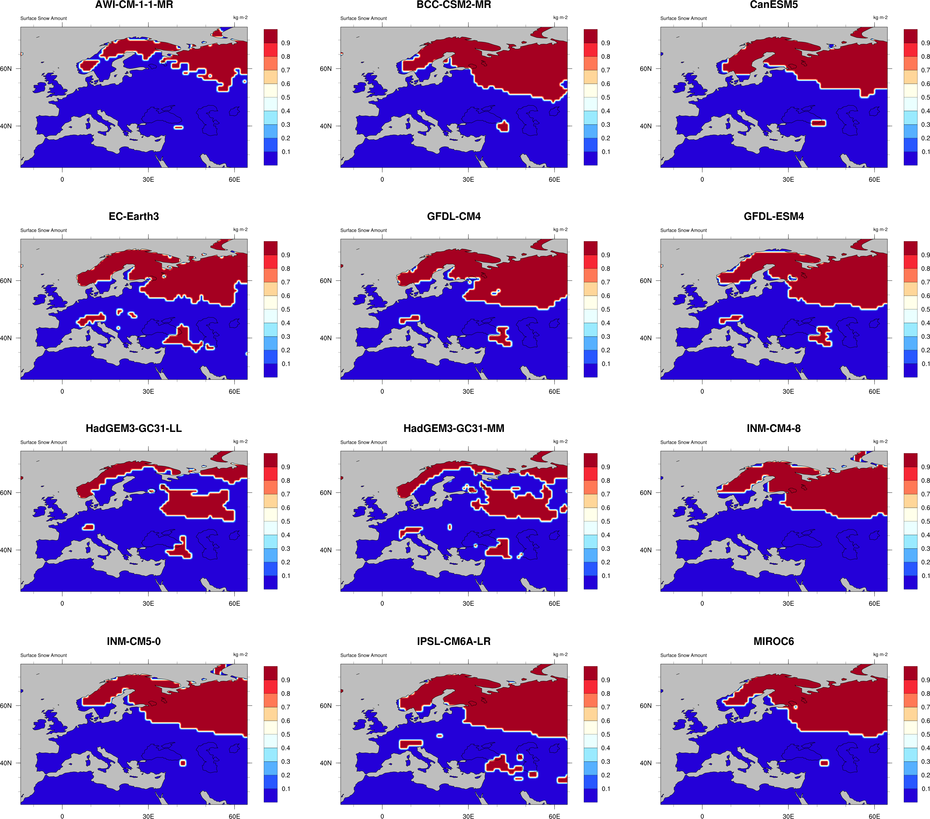

In [11]:
iplot_members(ccdo(llbox(cens(mask_dict), lonmin=-15, lonmax=65, latmin=25, latmax=75), operator='setmisstoc,0'),
              N=1, focus='land')

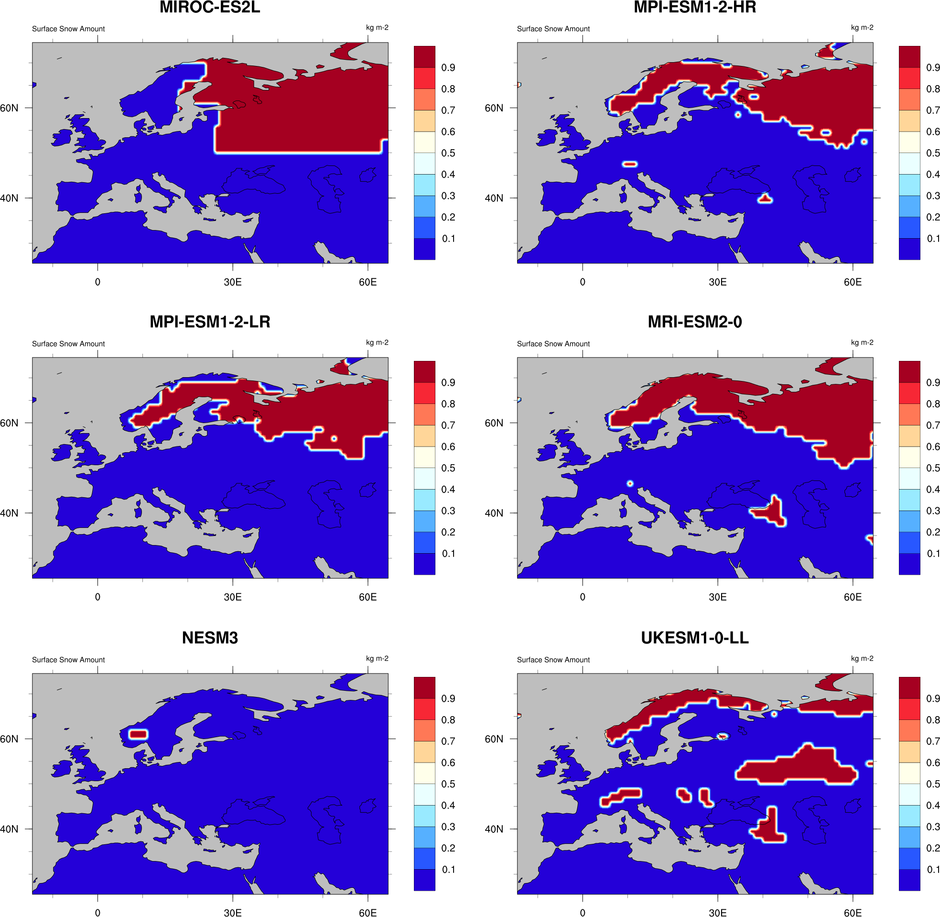

In [12]:
iplot_members(ccdo(llbox(cens(mask_dict), lonmin=-15, lonmax=65, latmin=25, latmax=75), operator='setmisstoc,0'),
              N=2, focus='land')

### Then GWLs (mix ssp126 and ssp585)

In [11]:
# -- Loop on the scenarios
ens_GWL_dict = dict()
for GWL in ['1.5','2','3','4']:
    #
    req_GWL = ds(project='snw_cmip6_GWL_ch12',
                 GWL = GWL,
                 model = '*',
                )
    GWL_ens = req_GWL.explore('ensemble')
    # -- Climatologies
    ens_GWL_dict[GWL] = GWL_ens

In [12]:
ens_GWL_dict['1.5'].keys()

['CanESM5_85',
 'BCC-CSM2-MR_85',
 'GFDL-CM4_85',
 'GFDL-ESM4_85',
 'HadGEM3-GC31-LL_85',
 'AWI-CM-1-1-MR_85',
 'IPSL-CM6A-LR_26',
 'MIROC6_26',
 'INM-CM4-8_26',
 'MIROC-ES2L_85',
 'IPSL-CM6A-LR_85',
 'UKESM1-0-LL_26',
 'MRI-ESM2-0_85',
 'INM-CM5-0_26',
 'EC-Earth3_26',
 'MRI-ESM2-0_26',
 'NESM3_85',
 'UKESM1-0-LL_85',
 'AWI-CM-1-1-MR_26',
 'CanESM5_26',
 'INM-CM5-0_85',
 'EC-Earth3_85',
 'MIROC-ES2L_26',
 'MIROC6_85',
 'NESM3_26',
 'BCC-CSM2-MR_26',
 'HadGEM3-GC31-LL_26',
 'MPI-ESM1-2-LR_85',
 'MPI-ESM1-2-LR_26',
 'INM-CM4-8_85']

In [13]:
ens_exp_dict.keys()

['85_1995_2014',
 '26_2081_2099',
 '85_2081_2099',
 '85_2041_2060',
 '26_2041_2060']

In [20]:
regional_averages = dict()

EUR_regions = ['NEU','WCE','MED','EEU']

# -- Loop on experiments / horizons
for ens_exp in ens_exp_dict:
    print ens_exp
    regional_averages[ens_exp] = dict()
    # -- Loop on the members of each ensemble
    for mem in ens_exp_dict[ens_exp]:
        print mem
        ttmp = average_over_AR6_region(cfile(ens_exp_dict[ens_exp][mem]), cfile(mask_dict[mem]), 'snw', EUR_regions)
        for region_name in EUR_regions:
            region_value = float(ttmp[EUR_regions.index(region_name)])
            print region_name, region_value
            if region_name not in regional_averages[ens_exp]:
                regional_averages[ens_exp][region_name] = [region_value]
            else:
                regional_averages[ens_exp][region_name].append(region_value)
if None:
    # -- Loop on experiments / horizons
    for ens_exp in ens_exp_dict:
        print ens_exp
        regional_averages[ens_exp] = dict()
        # -- Loop on the members of each ensemble
        for mem in ens_exp_dict[ens_exp]:
            print mem
            # -- Compute the averages for each AR6 region thanks to regionmask
            tmp = average_over_AR6_region(cfile(ens_exp_dict[ens_exp][mem]), cfile(mask_dict[mem]), 'snw', 'all')
            region_names = tmp.abbrevs
            for region_name in EUR_regions:
                print region_name
                region_value = float(tmp.sel(region=list(tmp.abbrevs).index(region_name))[0].values)
                print region_value
                if region_name not in regional_averages[ens_exp]:
                    regional_averages[ens_exp][region_name] = [region_value]
                else:
                    regional_averages[ens_exp][region_name].append(region_value)

85_1995_2014
MPI-ESM1-2-HR
NEU 38.6086959839
WCE 24.6542072296
MED 40.0818634033
EEU 41.5858764648
UKESM1-0-LL
NEU 50.016582489
WCE 22.1973075867
MED 28.1189613342
EEU 32.2030563354
HadGEM3-GC31-LL
NEU 59.5300483704
WCE 21.2038211823
MED 30.5789909363
EEU 24.6047554016
HadGEM3-GC31-MM
NEU 65.8373260498
WCE 24.9895839691
MED 38.6320648193
EEU 29.1989860535
MPI-ESM1-2-LR
NEU 36.0118865967
WCE 21.9127693176
MED nan
EEU 35.4369544983
MRI-ESM2-0
NEU 59.1092796326
WCE 26.9869232178
MED 48.9051361084
EEU 52.8880157471
IPSL-CM6A-LR
NEU 72.9649658203
WCE 39.9783325195
MED 41.1449966431
EEU 56.9951858521
INM-CM5-0
NEU 66.7271194458
WCE 39.1337585449
MED nan
EEU 62.0049667358
GFDL-CM4
NEU 51.7809028625
WCE 27.7573108673
MED 45.3803253174
EEU 42.0385665894
EC-Earth3
NEU 61.6522712708
WCE 33.8291549683
MED 46.289680481
EEU 53.4543571472
BCC-CSM2-MR
NEU 63.6229782104
WCE 27.9638366699
MED nan
EEU 51.8391036987
CanESM5
NEU 53.2165870667
WCE 29.2127094269
MED 21.2000007629
EEU 46.319442749
MIROC6
NEU 

In [21]:
regional_averages['85_2081_2099']['NEU']

[12.878082275390625,
 0.8815279006958008,
 13.002289772033691,
 22.880340576171875,
 2.3328115940093994,
 15.60573959350586,
 14.433562278747559,
 20.150148391723633,
 7.856411457061768,
 16.49659538269043,
 27.469680786132812,
 1.3103430271148682,
 10.643952369689941,
 0.0,
 37.944190979003906,
 22.880895614624023,
 4.080317974090576,
 7.261088848114014]

In [23]:
EUR_regions = ['NEU','WCE','MED','EEU']
for GWL in ens_GWL_dict :
    print GWL
    regional_averages[GWL] = dict()
    # -- Loop on the members of each ensemble
    for mem in ens_GWL_dict[GWL]:
        print mem
        ttmp = average_over_AR6_region(cfile(ens_GWL_dict[GWL][mem]),
                                       cfile(mask_dict[mem.replace('_85','').replace('_26','')]),
                                       'snw', EUR_regions)
        for region_name in EUR_regions:
            region_value = float(ttmp[EUR_regions.index(region_name)])
            print region_name, region_value
            if region_name not in regional_averages[GWL]:
                regional_averages[GWL][region_name] = [region_value]
            else:
                regional_averages[GWL][region_name].append(region_value)


if None:
    # -- Loop on experiments / horizons
    for GWL in ens_GWL_dict :
        print GWL
        regional_averages[GWL] = dict()
        # -- Loop on the members of each ensemble
        for mem in ens_GWL_dict[GWL]:
            print mem
            # -- Compute the averages for each AR6 region thanks to regionmask
            tmp = average_over_AR6_region(cfile(ens_GWL_dict[GWL][mem]), cfile(mask_dict[mem.replace('_85','').replace('_26','')]), 'snw', 'all')
            region_names = tmp.abbrevs
            for region_name in EUR_regions:
                print region_name
                region_value = float(tmp.sel(region=list(tmp.abbrevs).index(region_name))[0].values)
                print region_value
                if region_name not in regional_averages[GWL]:
                    regional_averages[GWL][region_name] = [region_value]
                else:
                    regional_averages[GWL][region_name].append(region_value)

1.5
CanESM5_85
NEU 48.3814849854
WCE 24.986618042
MED 16.1499996185
EEU 47.3183555603
BCC-CSM2-MR_85
NEU 53.1492919922
WCE 29.884344101
MED nan
EEU 56.2171440125
GFDL-CM4_85
NEU 39.2195396423
WCE 16.6771411896
MED 26.8478145599
EEU 29.7466220856
GFDL-ESM4_85
NEU 44.3427658081
WCE 18.563451767
MED 27.7010059357
EEU 39.1750450134
HadGEM3-GC31-LL_85
NEU 50.0215187073
WCE 14.1577100754
MED 15.3237028122
EEU 22.1624908447
AWI-CM-1-1-MR_85
NEU 27.3611927032
WCE 10.9510984421
MED 21.6554203033
EEU 28.3753147125
IPSL-CM6A-LR_26
NEU 72.1965179443
WCE 33.2379455566
MED 29.5869407654
EEU 51.9402580261
MIROC6_26
NEU 40.8480186462
WCE 21.7261886597
MED nan
EEU 46.8979492188
INM-CM4-8_26
NEU 69.5852737427
WCE 36.6321868896
MED nan
EEU 59.397151947
MIROC-ES2L_85
NEU 29.2982463837
WCE 21.0131549835
MED nan
EEU 45.3254318237
IPSL-CM6A-LR_85
NEU 71.2054367065
WCE 33.182723999
MED 31.4224319458
EEU 49.1720809937
UKESM1-0-LL_26
NEU 44.6986274719
WCE 9.26423072815
MED 14.4653778076
EEU 20.4930381775
MRI-ES

### Compute the ensemble statistics and save in a json file

In [24]:
quantiles_dict = dict()
nmodels_with_snow_in_baseline = dict()
for clim_period in regional_averages:
    quantiles_dict[clim_period] = dict()
    for region_name in regional_averages[clim_period]:
        print clim_period, region_name
        quantiles_dict[clim_period][region_name] = dict()
        dat = np.array(regional_averages[clim_period][region_name])
        wdat = dat[np.where(np.isnan(dat)==False)]
        if clim_period=='85_1995_2014':
            nmodels_with_snow_in_baseline[region_name] = len(wdat)
        if len(wdat)>5:        
            q10 = np.quantile(wdat, 0.1)
            q50 = np.quantile(wdat, 0.5)
            q90 = np.quantile(wdat, 0.9)
        else:
            q10 = -99999
            q50 = -99999
            q90 = -99999
        print [q10, q50, q90]
        quantiles_dict[clim_period][region_name] = [q10, q50, q90]

import json
ensemble = 'CMIP6'
outfilename = '/home/jservon/Chapter12_IPCC/data/snw/'+ensemble+'_EUR-11_snw_mask'+ndays+'_AR6_regional_averages.json'
with open(outfilename, 'w') as fp:
    json.dump(quantiles_dict, fp, sort_keys=True, indent=4)
outfilename = '/home/jservon/Chapter12_IPCC/data/Figure_12.9/'+ensemble+'_EUR-11_snw_mask'+ndays+'_AR6_regional_averages.json'
with open(outfilename, 'w') as fp:
    json.dump(quantiles_dict, fp, sort_keys=True, indent=4)

1.5 EEU
[26.835104560852052, 45.20551300048828, 56.95403709411622]
1.5 MED
[14.894540309906006, 26.565640449523926, 35.088478088378906]
1.5 NEU
[20.887250709533692, 44.29903602600098, 69.59732437133789]
1.5 WCE
[11.66635112762451, 21.277721405029297, 33.1992904663086]
85_1995_2014 EEU
[31.00142822265625, 51.83910369873047, 59.56420745849609]
85_1995_2014 MED
[22.71086311340332, 40.08186340332031, 48.90513610839844]
85_1995_2014 NEU
[35.118994522094724, 52.687856674194336, 67.0161033630371]
85_1995_2014 WCE
[21.884220123291016, 27.963836669921875, 39.471588134765625]
26_2041_2060 EEU
[16.69822120666504, 38.60061454772949, 54.64347839355469]
26_2041_2060 MED
[9.190814065933228, 23.837620735168457, 30.50807151794433]
26_2041_2060 NEU
[20.31632423400879, 43.169227600097656, 56.667917633056646]
26_2041_2060 WCE
[9.570310115814209, 16.690598964691162, 28.199851989746094]
3 EEU
[15.640119171142578, 26.30370330810547, 41.881430816650386]
3 MED
[4.555408954620361, 12.25, 16.134086227416994]
3 N

In [25]:
nmodels_with_snow_in_baseline

{'EEU': 17, 'MED': 11, 'NEU': 18, 'WCE': 17}

## CMIP5

In [26]:
exp_list = [
    # -- Baseline (ssp126 and ssp585 are the same files)
    dict(experiment='85',
         clim_period = '1995_2014'),    
    # -- Mid term
    dict(experiment='85',
         clim_period = '2041_2060'),
    dict(experiment='26',
         clim_period = '2041_2060'),
    # -- Late term
    dict(experiment='85',
         clim_period = '2081_2099'),
    dict(experiment='26',
         clim_period = '2081_2099'),
]

# -- Loop on the scenarios
ens_exp_dict = dict()
for exp in exp_list:
    #
    # -- Experiment and period
    experiment = exp['experiment']
    clim_period = exp['clim_period']
    
    # -- Create ensemble object for the scenario
    req_exp = ds(project='snw_cmip5_ch12',
                 experiment = experiment,
                 clim_period = clim_period,
                 model = '*'
                )
    ens_exp = req_exp.explore('ensemble')
    
    # -- Climatologies
    ens_exp_dict[experiment+'_'+clim_period] = clim_average(ens_exp, 'ANM')

ens_GWL_dict = dict()
for GWL in ['1.5','2','3','4']:
    #
    req_GWL = ds(project='snw_cmip5_GWL_ch12',
                 GWL = GWL,
                 model = '*'
                )
    GWL_ens = req_GWL.explore('ensemble')
    # -- Climatologies
    ens_GWL_dict[GWL] = GWL_ens

In [27]:
# -- Make a mask with baseline to keep only the grid points with more than 30 days
mask_dict = dict()
for mem in ens_exp_dict['85_1995_2014']:
    mask_dict[mem] = ccdo(ens_exp_dict['85_1995_2014'][mem], operator='setctomiss,0 -gtc,'+ndays)

In [28]:
regional_averages = dict()

EUR_regions = ['NEU','WCE','MED','EEU']

# -- Loop on experiments / horizons
for ens_exp in ens_exp_dict:
    print ens_exp
    regional_averages[ens_exp] = dict()
    # -- Loop on the members of each ensemble
    for mem in ens_exp_dict[ens_exp]:
        print mem
        ttmp = average_over_AR6_region(cfile(ens_exp_dict[ens_exp][mem]), cfile(mask_dict[mem]), 'snw', EUR_regions)
        for region_name in EUR_regions:
            region_value = float(ttmp[EUR_regions.index(region_name)])
            print region_name, region_value
            if region_name not in regional_averages[ens_exp]:
                regional_averages[ens_exp][region_name] = [region_value]
            else:
                regional_averages[ens_exp][region_name].append(region_value)

if None:
    # -- Loop on experiments / horizons
    for ens_exp in ens_exp_dict:
        print ens_exp
        regional_averages[ens_exp] = dict()
        # -- Loop on the members of each ensemble
        for mem in ens_exp_dict[ens_exp]:
            print mem
            # -- Compute the averages for each AR6 region thanks to regionmask
            tmp = average_over_AR6_region(cfile(ens_exp_dict[ens_exp][mem]), cfile(mask_dict[mem]), 'snw', 'all')
            region_names = tmp.abbrevs
            for region_name in EUR_regions:
                print region_name
                region_value = float(tmp.sel(region=list(tmp.abbrevs).index(region_name))[0].values)
                print region_value
                if region_name not in regional_averages[ens_exp]:
                    regional_averages[ens_exp][region_name] = [region_value]
                else:
                    regional_averages[ens_exp][region_name].append(region_value)

85_1995_2014
inmcm4
NEU 73.1993637085
WCE 42.9944763184
MED nan
EEU 71.1312332153
BNU-ESM
NEU 52.0637245178
WCE 37.993019104
MED nan
EEU 53.2449188232
FGOALS-g2
NEU 84.6478729248
WCE 51.8005065918
MED nan
EEU 81.2269592285
GFDL-ESM2G
NEU 46.2478561401
WCE 23.4388465881
MED nan
EEU 45.2202720642
MRI-CGCM3
NEU 91.0158081055
WCE 46.5542449951
MED 37.9305801392
EEU 66.2474212646
GFDL-ESM2M
NEU 45.1368980408
WCE 25.341047287
MED nan
EEU 42.079372406
NorESM1-M
NEU 55.9679412842
WCE 29.3772201538
MED nan
EEU 55.1290931702
CSIRO-Mk3-6-0
NEU 37.0872459412
WCE 34.0372047424
MED nan
EEU 49.9775123596
GFDL-CM3
NEU 60.1232566833
WCE 24.3766727448
MED 14.75
EEU 42.599067688
MIROC-ESM
NEU 55.5450820923
WCE 39.5037384033
MED nan
EEU 59.6813735962
CNRM-CM5
NEU 63.4008483887
WCE 41.6080284119
MED 56.9084243774
EEU 58.3632850647
HadGEM2-ES
NEU 42.6285934448
WCE 24.3801269531
MED nan
EEU 42.4049301147
CanESM2
NEU 44.3617744446
WCE 34.3524627686
MED 20.25
EEU 55.6169281006
MIROC-ESM-CHEM
NEU 59.720161438
W

In [29]:
for GWL in ens_GWL_dict :
    print GWL
    regional_averages[GWL] = dict()
    # -- Loop on the members of each ensemble
    for mem in ens_GWL_dict[GWL]:
        print mem
        ttmp = average_over_AR6_region(cfile(ens_GWL_dict[GWL][mem]), cfile(mask_dict[mem.replace('_85','').replace('_26','')]), 'snw', EUR_regions)
        for region_name in EUR_regions:
            region_value = float(ttmp[EUR_regions.index(region_name)])
            print region_name, region_value
            if region_name not in regional_averages[GWL]:
                regional_averages[GWL][region_name] = [region_value]
            else:
                regional_averages[GWL][region_name].append(region_value)

if None:
    # -- Loop on experiments / horizons
    for GWL in ens_GWL_dict :
        print GWL
        regional_averages[GWL] = dict()
        # -- Loop on the members of each ensemble
        for mem in ens_GWL_dict[GWL]:
            print mem
            # -- Compute the averages for each AR6 region thanks to regionmask
            tmp = average_over_AR6_region(cfile(ens_GWL_dict[GWL][mem]), cfile(mask_dict[mem.replace('_85','').replace('_26','')]), 'snw', 'all')
            region_names = tmp.abbrevs
            for region_name in EUR_regions:
                print region_name
                region_value = float(tmp.sel(region=list(tmp.abbrevs).index(region_name))[0].values)
                print region_value
                if region_name not in regional_averages[GWL]:
                    regional_averages[GWL][region_name] = [region_value]
                else:
                    regional_averages[GWL][region_name].append(region_value)

1.5
MPI-ESM-MR_26
NEU 19.422914505
WCE nan
MED nan
EEU 28.0197219849
MIROC-ESM_85
NEU 44.7548141479
WCE 24.9259929657
MED nan
EEU 53.0664901733
MIROC5_26
NEU 44.6995620728
WCE 35.6536865234
MED nan
EEU 57.8327789307
MRI-CGCM3_85
NEU 81.2061538696
WCE 18.8309230804
MED 25.6974639893
EEU 55.5876502991
MPI-ESM-LR_85
NEU 16.3715782166
WCE 9.22261047363
MED nan
EEU 27.9511585236
GFDL-ESM2G_85
NEU 38.216506958
WCE 15.1927947998
MED nan
EEU 31.9634456635
MPI-ESM-MR_85
NEU 14.1683683395
WCE nan
MED nan
EEU 31.8453903198
bcc-csm1-1-m_85
NEU 83.4120407104
WCE 31.2067680359
MED nan
EEU 63.653049469
MIROC-ESM_26
NEU 39.7621307373
WCE 25.4355564117
MED nan
EEU 50.1249885559
HadGEM2-CC_85
NEU 37.4581108093
WCE 10.6721811295
MED nan
EEU 41.737323761
CanESM2_85
NEU 38.6323509216
WCE 30.8789806366
MED 13.0500011444
EEU 49.7956161499
CSIRO-Mk3-6-0_26
NEU 33.6595230103
WCE 29.3117980957
MED nan
EEU 48.6092987061
GFDL-CM3_85
NEU 34.5506134033
WCE 7.54092407227
MED 1.69999992847
EEU 29.3260059357
CNRM-CM5_

In [30]:
import numpy
quantiles_dict = dict()
nmodels_with_snow_in_baseline = dict()
for clim_period in regional_averages:
    quantiles_dict[clim_period] = dict()
    for region_name in regional_averages[clim_period]:
        print clim_period, region_name
        quantiles_dict[clim_period][region_name] = dict()
        dat = np.array(regional_averages[clim_period][region_name])
        wdat = dat[np.where(np.isnan(dat)==False)]
        if clim_period=='85_1995_2014':
            nmodels_with_snow_in_baseline[region_name] = len(wdat)
        if len(wdat)>=3:        
            q10 = np.quantile(wdat, 0.1)
            q50 = np.quantile(wdat, 0.5)
            q90 = np.quantile(wdat, 0.9)
        else:
            q10 = -99999
            q50 = -99999
            q90 = -99999
        quantiles_dict[clim_period][region_name] = [q10, q50, q90]

import json
ensemble = 'CMIP5'
outfilename = '/home/jservon/Chapter12_IPCC/data/snw/'+ensemble+'_EUR-11_snw_mask'+ndays+'_AR6_regional_averages.json'
#print outfilename
with open(outfilename, 'w') as fp:
    json.dump(quantiles_dict, fp, sort_keys=True, indent=4)
outfilename = '/home/jservon/Chapter12_IPCC/data/Figure_12.9/'+ensemble+'_EUR-11_snw_mask'+ndays+'_AR6_regional_averages.json'
#print outfilename
with open(outfilename, 'w') as fp:
    json.dump(quantiles_dict, fp, sort_keys=True, indent=4)

1.5 EEU
1.5 MED
1.5 NEU
1.5 WCE
85_1995_2014 EEU
85_1995_2014 MED
85_1995_2014 NEU
85_1995_2014 WCE
26_2041_2060 EEU
26_2041_2060 MED
26_2041_2060 NEU
26_2041_2060 WCE
3 EEU
3 MED
3 NEU
3 WCE
26_2081_2099 EEU
26_2081_2099 MED
26_2081_2099 NEU
26_2081_2099 WCE
4 EEU
4 MED
4 NEU
4 WCE
85_2041_2060 EEU
85_2041_2060 MED
85_2041_2060 NEU
85_2041_2060 WCE
2 EEU
2 MED
2 NEU
2 WCE
85_2081_2099 EEU
85_2081_2099 MED
85_2081_2099 NEU
85_2081_2099 WCE


In [13]:
nmodels_with_snow_in_baseline

{'EEU': 21, 'MED': 5, 'NEU': 21, 'WCE': 20}

## EURO-CORDEX

In [1]:
from climaf.api import *

import regionmask
def weighted_mean(da, weights, dim):
    """Reduce da by a weighted mean along some dimension(s).

    Parameters
    ----------
    da : DataArray
        Object over which the weighted reduction operation is applied.    
    weights : DataArray
        An array of weights associated with the values in this Dataset.
    dim : str or sequence of str, optional
        Dimension(s) over which to apply the weighted `mean`.
        
    Returns
    -------
    weighted_mean : DataArray
        New DataArray with weighted mean applied to its data and
        the indicated dimension(s) removed.
    """

    weighted_sum = (da * weights).sum(dim=dim, skipna=True)
    # need to mask weights where data is not valid
    masked_weights = weights.where(da.notnull())
    sum_of_weights = masked_weights.sum(dim=dim, skipna=True)
    valid_weights = sum_of_weights != 0
    sum_of_weights = sum_of_weights.where(valid_weights)

    return weighted_sum / sum_of_weights

def average_over_AR6_region(filename, mask_sup30, variable, region_name):

    # -- AR6 regions
    #ar6_all = regionmask.defined_regions.ar6.all
    # -- Get the regions
    ar6_land = regionmask.defined_regions.ar6.land

    #ax = ar6_all.plot()
    # -- Get land/sea mask (generic)
    land_110 = regionmask.defined_regions.natural_earth.land_110

    # -- Get data
    ds = xr.open_dataset(filename, decode_times=False)
    dat = ds[variable]
    dat.values = np.array(dat.values, dtype=np.float32)

    # -- Get the mask of values > 30
    mask_ds = xr.open_dataset(mask_sup30, decode_times=False)
    mask = mask_ds[variable]
    mask.values = np.array(mask.values, dtype=np.float32)
    #
    # -- Mask the data
    dat.values = dat.values * mask.values

    # -- Mask the data
    mask_3D = ar6_land.mask_3D(dat) # AR6 mask
    land_mask = land_110.mask_3D(dat) # Land sea mask
    mask_lsm = mask_3D * land_mask.squeeze(drop=True) # Combine the two

    weights = np.cos(np.deg2rad(dat.lat))
    
    if region_name=='all':
        return weighted_mean(dat, mask_3D * weights, ("lon", "lat"))
    else:
        if isinstance(region_name, list):
            res = list()
            for region in region_name:
                region_mask = mask_lsm.isel(region=list(mask_3D.abbrevs).index(region))
                dat_region = dat.where(region_mask)
                weights_region = weights.where(region_mask)
                res.append( weighted_mean(dat_region, region_mask*weights_region, ("lon","lat")) )
            return res
        else:
            region_mask = mask_lsm.isel(region=list(mask_3D.abbrevs).index(region_name))
            dat_region = dat.where(region_mask)
            weights_region = weights.where(region_mask) 
            return weighted_mean(dat_region, region_mask*weights_region, ("lon","lat"))
    
def regions_contained(lon, lat, regions):

    # determine if the longitude needs to be wrapped
    regions_is_180 = regions.lon_180
    grid_is_180 = regionmask.core.utils._is_180(lon.min(), lon.max())

    wrap_lon = not regions_is_180 == grid_is_180

    lon_orig = lon.copy()
    if wrap_lon:
        lon = regionmask.core.utils._wrapAngle(lon, wrap_lon)

    lon = np.asarray(lon).squeeze()
    lat = np.asarray(lat).squeeze()

    if lon.ndim == 1 and lat.ndim == 1:
        poly = shapely.geometry.box(lon.min(), lat.min(), lon.max(), lat.max())

    else:
        raise ValueError("Cannot currently handle 2D coordinates")

    fully_contained = list()
    for region_poly in regions.polygons:
        res = poly.contains(region_poly)

        fully_contained.append(res)

    return xr.DataArray(
        fully_contained, dims=["region"], coords=dict(region=regions.numbers)
    )

if None:
    region_name = "all"
    variable = 'tx35'
    filename = "/data/jservon/IPCC/tx35/individual_models/CMIP6_ssp585_tx35_2100_NorESM2-LM_r1i1p1f1.nc"

    tmp = average_over_AR6_region(filename, variable, region_name)
    tmp

CliMAF version = 1.2.13


CliMAF install => /ciclad-home/jservon/Evaluation/CliMAF/climaf_installs/climaf_V1.2.13_post
python => /modfs/modtools/miniconda2/envs/analyse_2.7_v2/bin/python
---
Required softwares to run CliMAF => you are using the following versions/installations:
ncl 6.6.2 => /modfs/modtools/miniconda2/envs/analyse_2.7_v2/bin/ncl
cdo 1.9.6 => /opt/nco/1.9/bin/cdo
nco (ncks) 4.5.2 => /opt/nco-4.5.2/bin/ncks
ncdump fichier => /modfs/modtools/miniconda2/envs/analyse_2.7_v2/bin/ncdump
Check stamping requirements
nco (ncatted) found -> /opt/nco-4.5.2/bin/ncatted
convert found -> /usr/bin/convert
pdftk found -> /usr/bin/pdftk
exiv2 found -> /ciclad-home/jservon/Evaluation/CliMAF/climaf_installs/climaf_V1.2.13_post/bin/exiv2
---


Cache directory set to : /data/jservon/climafcache (use $CLIMAF_CACHE if set) 
Cache directory for remote data set to : /data/jservon/climafcache/remote_data (use $CLIMAF_REMOTE_CACHE if set) 
Available macros read from ~/.climaf.macros are : []


In [31]:
# -- CORDEX
pattern ='/projsu/cmip-work/rvautard/IPCC/SWE${experiment}/snw100seas.${model}.${clim_period}.meanG.nc'
cproject('SWE_cordex_ch12','experiment',('period','fx'),'clim_period','model', ('variable','snw'), ensemble=['model'], separator='%')
dataloc(project='SWE_cordex_ch12', url=pattern) 

clog('critical')

exp_list = [
    # -- Baseline (ssp126 and ssp585 are the same files)
    dict(experiment='RCP85',
         clim_period = 'ref'),    
    # -- Mid term
    dict(experiment='RCP85',
         clim_period = 'mce'),
    dict(experiment='RCP26',
         clim_period = 'mce'),
    # -- Late term
    dict(experiment='RCP85',
         clim_period = 'ece'),
    dict(experiment='RCP26',
         clim_period = 'ece'),
]

ens_exp_dict = dict()
ens_GWL_dict = dict()

for exp in exp_list:
    #
    # -- Experiment and period
    experiment = exp['experiment']
    clim_period = exp['clim_period']

    # -- Create ensemble object for the scenario
    req_dict = dict(project='SWE_cordex_ch12',
                  experiment = experiment,
                  clim_period = clim_period,
                 )
    #
    req_exp = ds(model = '*', **req_dict)
    lom = req_exp.explore('choices')['model']

    ens_dict = dict()
    for model in lom:
        ens_dict[model] = ds(model=model, **req_dict).explore('resolve')
    ens = cens(ens_dict)
    
    ens_exp_dict[experiment+'_'+clim_period] = ens
    

In [32]:
# -- Make a mask with baseline to keep only the grid points with more than 30 days
mask_dict = dict()
for mem in ens_exp_dict['RCP85_ref']:
    mask_dict[mem] = ccdo(ens_exp_dict['RCP85_ref'][mem], operator='setctomiss,0 -gtc,14')

In [33]:
mask_dict

{'CANESMr1-CCLM': ccdo(ds('SWE_cordex_ch12%%snw%fx%global%RCP85%ref%CANESMr1-CCLM'),operator='setctomiss,0 -gtc,14'),
 'CANESMr1-REMO': ccdo(ds('SWE_cordex_ch12%%snw%fx%global%RCP85%ref%CANESMr1-REMO'),operator='setctomiss,0 -gtc,14'),
 'CNRMr1-ALADIN53': ccdo(ds('SWE_cordex_ch12%%snw%fx%global%RCP85%ref%CNRMr1-ALADIN53'),operator='setctomiss,0 -gtc,14'),
 'CNRMr1-ALADIN63': ccdo(ds('SWE_cordex_ch12%%snw%fx%global%RCP85%ref%CNRMr1-ALADIN63'),operator='setctomiss,0 -gtc,14'),
 'CNRMr1-CCLM': ccdo(ds('SWE_cordex_ch12%%snw%fx%global%RCP85%ref%CNRMr1-CCLM'),operator='setctomiss,0 -gtc,14'),
 'CNRMr1-HIRHAM': ccdo(ds('SWE_cordex_ch12%%snw%fx%global%RCP85%ref%CNRMr1-HIRHAM'),operator='setctomiss,0 -gtc,14'),
 'CNRMr1-RACMO': ccdo(ds('SWE_cordex_ch12%%snw%fx%global%RCP85%ref%CNRMr1-RACMO'),operator='setctomiss,0 -gtc,14'),
 'CNRMr1-REMO': ccdo(ds('SWE_cordex_ch12%%snw%fx%global%RCP85%ref%CNRMr1-REMO'),operator='setctomiss,0 -gtc,14'),
 'CNRMr1-WRF381P': ccdo(ds('SWE_cordex_ch12%%snw%fx%global

In [34]:
common_grid = '/home/jservon/Chapter12_IPCC/data/Figure_12.9/EUROPE_raw_common_grid.nc'

In [35]:
import xarray as xr
regional_averages = dict()

EUR_regions = ['NEU','EEU','WCE','MED']

# -- Loop on experiments / horizons
for ens_exp in ens_exp_dict:
    print ens_exp
    regional_averages[ens_exp] = dict()
    # -- Loop on the members of each ensemble
    for mem in ens_exp_dict[ens_exp]:
        if mem in mask_dict:
            print mem
            #ttmp = average_over_AR6_region(cfile(ens_exp_dict[ens_exp][mem]), cfile(mask_dict[mem]), 'snw', EUR_regions)
            ttmp = average_over_AR6_region(cfile(regridn(ens_exp_dict[ens_exp][mem], cdogrid=common_grid)),
                                           cfile(regridn(mask_dict[mem], cdogrid=common_grid, option='remapnn')),
                                          'snw', EUR_regions)
            for region_name in EUR_regions:
                region_value = float(ttmp[EUR_regions.index(region_name)])
                print region_name, region_value
                if region_name not in regional_averages[ens_exp]:
                    regional_averages[ens_exp][region_name] = [region_value]
                else:
                    regional_averages[ens_exp][region_name].append(region_value)

if None:
    print mem
    # -- Compute the averages for each AR6 region thanks to regionmask
    tmp = average_over_AR6_region(cfile(regridn(ens_exp_dict[ens_exp][mem], cdogrid=common_grid)),
                                  cfile(regridn(mask_dict[mem], cdogrid=common_grid, option='remapnn')),
                                  'snw', 'all')
    region_names = tmp.abbrevs
    for region_name in EUR_regions:
        print region_name
        region_value = float(tmp.isel(region=list(tmp.abbrevs).index(region_name)).values)
        print region_value
        if region_name not in regional_averages[ens_exp]:
            regional_averages[ens_exp][region_name] = [region_value]
        else:
            regional_averages[ens_exp][region_name].append(region_value)


RCP26_ece
MPIr1-RACMO
NEU 69.1104202271
EEU 59.6338272095
WCE 32.4595718384
MED 43.7969932556
CNRMr1-REMO
NEU 36.0125007629
EEU 55.8118743896
WCE 18.9817256927
MED 22.7921524048
ECEARTHr12-CCLM
NEU 77.7977828979
EEU 60.2864685059
WCE 41.7476882935
MED 39.1773948669
ECEARTHr3-HIRHAM
NEU 49.0670204163
EEU 58.4060249329
WCE 35.8582611084
MED 38.3064994812
HADGEMr1-HIRHAM
NEU 31.6364040375
EEU 40.8896903992
WCE 29.0914497375
MED 26.1472873688
CNRMr1-ALADIN63
NEU 58.8274116516
EEU 38.0310096741
WCE 28.3119277954
MED 33.6762580872
NORESMr1-RCA
NEU 55.6213798523
EEU 34.0793457031
WCE 52.4716339111
MED 34.8236732483
NORESMr1-RACMO
NEU 74.6228713989
EEU 48.8948173523
WCE 32.688293457
MED 39.2332649231
HADGEMr1-HADREM
NEU 48.9400749207
EEU 42.9986381531
WCE 33.9994392395
MED 28.8663597107
MPIr1-REMO
NEU 41.5190620422
EEU 54.4985694885
WCE 27.0557765961
MED 21.2250003815
HADGEMr1-REGCM
NEU 39.3640022278
EEU 54.0369911194
WCE 26.3215751648
MED 27.8864192963
MPIr1-CCLM
NEU 65.9304122925
EEU 47.3988

NEU 64.9482345581
EEU 65.39478302
WCE 43.7929344177
MED 46.951335907
HADGEMr1-HIRHAM
NEU 53.7615318298
EEU 55.2714805603
WCE 44.8385734558
MED 43.2152862549
CNRMr1-WRF381P
NEU 72.0019226074
EEU 68.9683074951
WCE 44.1057357788
MED 49.3949279785
ECEARTHr1-RCA
NEU 70.1898193359
EEU 60.1924514771
WCE 56.2729034424
MED 47.7178039551
HADGEMr1-HADREM
NEU 66.7256240845
EEU 56.2450485229
WCE 44.0894241333
MED 47.7613067627
MPIr1-HIRHAM
NEU 56.3888549805
EEU 63.1025733948
WCE 43.8386917114
MED 42.2667121887
IPSLr1-WRF381P
NEU 86.2336883545
EEU 77.4012680054
WCE 56.3567428589
MED 59.07579422
ECEARTHr3-RACMO
NEU 83.1241226196
EEU 76.4098892212
WCE 46.156879425
MED 50.7410774231
HADGEMr1-REGCM
NEU 56.0172424316
EEU 72.3141708374
WCE 40.4567375183
MED 42.266078949
ECEARTHr1-HIRHAM
NEU 65.4861373901
EEU 68.3157958984
WCE 44.0909004211
MED 43.8108139038
MPIr3-COSMOcrCLIM
NEU 69.5221405029
EEU 60.7652740479
WCE 50.3803291321
MED 41.4488525391
NORESMr1-REMO
NEU 51.7546730042
EEU 62.4718437195
WCE 33.578

NEU 43.5993804932
EEU 53.5028305054
WCE 33.9490242004
MED 31.2115745544
MPIr3-COSMOcrCLIM
NEU 50.8302345276
EEU 44.6343307495
WCE 37.7449226379
MED 24.3798751831
NORESMr1-REMO
NEU 25.1337509155
EEU 37.4383850098
WCE 14.5470638275
MED 19.1661109924
MPIr2-COSMOcrCLIM
NEU 50.4375228882
EEU 49.2353057861
WCE 27.3309726715
MED 24.4422225952
MPIr2-RCA
NEU 45.6360282898
EEU 27.9423770905
WCE 39.6565475464
MED 27.2714538574
HADGEMr1-COSMOcrCLIM
NEU 41.55235672
EEU 39.9870834351
WCE 23.875957489
MED 23.1947860718
MPIr1-ALADIN63
NEU 47.7432670593
EEU 26.334072113
WCE 41.8235740662
MED 26.9196796417
ECEARTHr12-REMO
NEU 29.7869091034
EEU 44.6371192932
WCE 18.9671783447
MED 21.0281429291
NORESMr1-HIRHAM
NEU 44.6691589355
EEU 31.9635829926
WCE 33.688621521
MED 30.5481281281
ECEARTHr12-RACMO
NEU 61.7343978882
EEU 54.2498283386
WCE 28.6126937866
MED 34.3383102417
ECEARTHr12-HADREM
NEU 56.7127914429
EEU 47.9786529541
WCE 28.6824092865
MED 28.7334957123
ECEARTHr12-HIRHAM
NEU 44.7623977661
EEU 43.3452377

In [36]:
ens_GWL_dict = dict()
for GWL in ['15','2','3','4']:
    #
    req_GWL = ds(project='SWE_cordex_ch12',
                 experiment='GWL',
                 clim_period = 'gwl'+GWL,
                 model = '*',
                )
    GWL_ens = req_GWL.explore('ensemble')
    # -- Climatologies
    ens_GWL_dict[GWL] = GWL_ens

In [37]:
wmask_dict = dict()

# -- Loop on experiments / horizons
for GWL in ens_GWL_dict :
    print GWL
    regional_averages[GWL] = dict()
    # -- Loop on the members of each ensemble
    for mem in ens_GWL_dict[GWL]:
        print mem
        ttmp = average_over_AR6_region(cfile(regridn(ens_GWL_dict[GWL][mem], cdogrid=common_grid)),
                                       cfile(regridn(mask_dict[mem], cdogrid=common_grid, option='remapnn')),
                                      'snw', EUR_regions)
        #ttmp = average_over_AR6_region(cfile(ens_GWL_dict[GWL][mem]), cfile(mask_dict[mem.replace('_85','').replace('_26','')]), 'snw', EUR_regions)
        for region_name in EUR_regions:
            region_value = float(ttmp[EUR_regions.index(region_name)])
            print region_name, region_value
            if region_name not in regional_averages[GWL]:
                regional_averages[GWL][region_name] = [region_value]
            else:
                regional_averages[GWL][region_name].append(region_value)

if None:
    # -- Loop on experiments / horizons
    for GWL in ens_GWL_dict :
        print GWL
        regional_averages[GWL] = dict()
        # -- Loop on the members of each ensemble
        for mem in ens_GWL_dict[GWL]:
            if mem in mask_dict:
                print mem
                # -- Compute the averages for each AR6 region thanks to regionmask
                tmp = average_over_AR6_region(cfile(regridn(ens_GWL_dict[GWL][mem], cdogrid=common_grid)),
                                              cfile(regridn(mask_dict[mem], cdogrid=common_grid, option='remapnn')),
                                              'snw', 'all')
                region_names = tmp.abbrevs
                for region_name in EUR_regions:
                    print region_name
                    region_value = float(tmp.isel(region=list(tmp.abbrevs).index(region_name)).values)
                    print region_value
                    if region_name not in regional_averages[GWL]:
                        regional_averages[GWL][region_name] = [region_value]
                    else:
                        regional_averages[GWL][region_name].append(region_value)


3
ECEARTHr12-WRF381P
NEU 40.7253456116
EEU 51.5181694031
WCE 23.3354263306
MED 28.1576385498
MPIr1-COSMOcrCLIM
NEU 44.1359939575
EEU 35.9743728638
WCE 22.1810779572
MED 20.6158256531
HADGEMr1-WRF381P
NEU 46.2297210693
EEU 45.7425270081
WCE 24.6575737
MED 27.9179706573
HADGEMr1-WRF361H
NEU 55.3659172058
EEU 69.4571838379
WCE 27.7594261169
MED 28.5626010895
CNRMr1-REMO
NEU 27.2905883789
EEU 44.1608009338
WCE 11.5797224045
MED 15.6168994904
CANESMr1-CCLM
NEU 53.6825866699
EEU 43.1870803833
WCE 29.2249755859
MED 24.270570755
ECEARTHr12-CCLM
NEU 48.8020973206
EEU 44.9917907715
WCE 23.2480831146
MED 21.6092281342
IPSLr1-RACMO
NEU 72.4425125122
EEU 58.3725776672
WCE 29.6592788696
MED 31.0872402191
ECEARTHr3-HIRHAM
NEU 36.6284713745
EEU 39.4147605896
WCE 23.9169273376
MED 28.9051761627
HADGEMr1-HIRHAM
NEU 26.2304801941
EEU 32.295249939
WCE 27.3254737854
MED 23.1530628204
CNRMr1-WRF381P
NEU 47.7022781372
EEU 45.9835929871
WCE 15.2699537277
MED 18.2347640991
ECEARTHr1-RCA
NEU 40.8312110901
EEU 3

NEU 47.3341941833
EEU 25.894990921
WCE 44.0633621216
MED 28.19140625
ECEARTHr12-WRF361H
NEU 78.6071014404
EEU 83.0073165894
WCE 46.3520812988
MED 42.5384864807
NORESMr1-ALADIN63
NEU 55.4375991821
EEU 22.0262775421
WCE 42.9056053162
MED 30.8089580536
MIROCr1-REMO
NEU 41.0204124451
EEU 67.0631408691
WCE 24.2372913361
MED 15.2312412262
MPIr1-CCLM
NEU 56.1496658325
EEU 46.571937561
WCE 32.7395782471
MED 39.9565315247
CNRMr1-CCLM
NEU 67.4785690308
EEU 51.0294952393
WCE 26.8138275146
MED 36.6379890442
ECEARTHr3-RCA
NEU 53.4192657471
EEU 40.9423828125
WCE 40.5616989136
MED 29.389093399
MPIr1-REMO
NEU 30.2481155396
EEU 52.8611106873
WCE 26.1063938141
MED 22.1905536652
NORESMr1-COSMOcrCLIM
NEU 64.2935028076
EEU 35.2784004211
WCE 28.5415916443
MED 26.3459300995
MPIr2-REMO
NEU 30.7682476044
EEU 48.8334846497
WCE 19.1625614166
MED 21.007768631
MPIr1-WRF361H
NEU 67.9229278564
EEU 75.9165344238
WCE 39.4387207031
MED 41.1109886169
NORESMr1-HADREM
NEU 60.6393318176
EEU 39.5620002747
WCE 37.2872543335


NEU 24.0034294128
EEU 24.9306259155
WCE 17.1904239655
MED 13.8128585815
IPSLr1-WRF381P
NEU 57.1747169495
EEU 48.1008338928
WCE 19.0159339905
MED 18.800693512
ECEARTHr3-RACMO
NEU 39.6084671021
EEU 34.4620246887
WCE 15.1773557663
MED 21.9466552734
HADGEMr1-REGCM
NEU 27.9726028442
EEU 40.8902854919
WCE 11.7289838791
MED 11.3785037994
ECEARTHr1-HIRHAM
NEU 26.4369392395
EEU 31.67461586
WCE 17.8747577667
MED 16.9667549133
MPIr3-COSMOcrCLIM
NEU 35.9988555908
EEU 33.190284729
WCE 20.780670166
MED 13.4508895874
MPIr2-COSMOcrCLIM
NEU 37.6028785706
EEU 26.9914226532
WCE 16.3310050964
MED 12.3440074921
MPIr2-RCA
NEU 28.2963237762
EEU 14.2125291824
WCE 27.1120624542
MED 11.6062736511
HADGEMr1-COSMOcrCLIM
NEU 27.6662025452
EEU 21.4010944366
WCE 14.8073225021
MED 12.6186552048
MPIr1-ALADIN63
NEU 33.9930229187
EEU 15.2217597961
WCE 28.5412559509
MED 13.1205320358
ECEARTHr12-REMO
NEU 8.483045578
EEU 29.1874580383
WCE 8.8544883728
MED 10.4529390335
ECEARTHr12-RACMO
NEU 36.5614700317
EEU 33.481098175
WCE

In [10]:
wmask_dict

{}

In [38]:
import numpy
quantiles_dict = dict()
for clim_period in regional_averages:
    quantiles_dict[clim_period] = dict()
    for region_name in regional_averages[clim_period]:
        print clim_period, region_name
        quantiles_dict[clim_period][region_name] = dict()
        dat = np.array(regional_averages[clim_period][region_name])
        wdat = dat[np.where(np.isnan(dat)==False)]
        if len(wdat)>=3:        
            q10 = np.quantile(wdat, 0.1)
            q50 = np.quantile(wdat, 0.5)
            q90 = np.quantile(wdat, 0.9)
        else:
            q10 = -99999
            q50 = -99999
            q90 = -99999
        quantiles_dict[clim_period][region_name] = [q10, q50, q90]

import json
ensemble = 'EURO-CORDEX'
outfilename = '/home/jservon/Chapter12_IPCC/data/Figure_12.9/'+ensemble+'_SWE_mask14_AR6_regional_averages.json'
#print outfilename
with open(outfilename, 'w') as fp:
    json.dump(quantiles_dict, fp, sort_keys=True, indent=4)

15 EEU
15 MED
15 NEU
15 WCE
RCP85_ref EEU
RCP85_ref MED
RCP85_ref NEU
RCP85_ref WCE
3 EEU
3 MED
3 NEU
3 WCE
2 EEU
2 MED
2 NEU
2 WCE
4 EEU
4 MED
4 NEU
4 WCE
RCP26_ece EEU
RCP26_ece MED
RCP26_ece NEU
RCP26_ece WCE
RCP85_mce EEU
RCP85_mce MED
RCP85_mce NEU
RCP85_mce WCE
RCP26_mce EEU
RCP26_mce MED
RCP26_mce NEU
RCP26_mce WCE
RCP85_ece EEU
RCP85_ece MED
RCP85_ece NEU
RCP85_ece WCE


In [ ]:
# If region is not entireley covered => 0
# Do the map with regions on top and hatching
# Start the barplot:
# - retrieve values from json file
# - do the plot for one region
# Start to build the multiplot
# 

#  
#  
#  

In [26]:
regionmask.defined_regions.ar6.all.abbrevs.index('CAR')

8

In [12]:
ar6_land = regionmask.defined_regions.ar6.land
ar6_land

<regionmask.Regions>
Name:     AR6 reference regions (land only)
Source:   Iturbide et al., 2020 (Earth Syst. Sci. Data)

Regions:
  0  GIC  Greenland/Iceland
  1  NWN  N.W.North-America
  2  NEN  N.E.North-America
  3  WNA    W.North-America
  4  CNA    C.North-America
..   ...                ...
 41  EAU        E.Australia
 42  SAU        S.Australia
 43   NZ        New-Zealand
 44  EAN       E.Antarctica
 45  WAN       W.Antarctica

[46 regions]

In [13]:
ar6_land.abbrevs

[u'GIC',
 u'NWN',
 u'NEN',
 u'WNA',
 u'CNA',
 u'ENA',
 u'NCA',
 u'SCA',
 u'CAR',
 u'NWS',
 u'NSA',
 u'NES',
 u'SAM',
 u'SWS',
 u'SES',
 u'SSA',
 u'NEU',
 u'WCE',
 u'EEU',
 u'MED',
 u'SAH',
 u'WAF',
 u'CAF',
 u'NEAF',
 u'SEAF',
 u'WSAF',
 u'ESAF',
 u'MDG',
 u'RAR',
 u'WSB',
 u'ESB',
 u'RFE',
 u'WCA',
 u'ECA',
 u'TIB',
 u'EAS',
 u'ARP',
 u'SAS',
 u'SEA',
 u'NAU',
 u'CAU',
 u'EAU',
 u'SAU',
 u'NZ',
 u'EAN',
 u'WAN']

In [14]:
ar6_land.names

[u'Greenland/Iceland',
 u'N.W.North-America',
 u'N.E.North-America',
 u'W.North-America',
 u'C.North-America',
 u'E.North-America',
 u'N.Central-America',
 u'S.Central-America',
 u'Caribbean',
 u'N.W.South-America',
 u'N.South-America',
 u'N.E.South-America',
 u'South-American-Monsoon',
 u'S.W.South-America',
 u'S.E.South-America',
 u'S.South-America',
 u'N.Europe',
 u'West&Central-Europe',
 u'E.Europe',
 u'Mediterranean',
 u'Sahara',
 u'Western-Africa',
 u'Central-Africa',
 u'N.Eastern-Africa',
 u'S.Eastern-Africa',
 u'W.Southern-Africa',
 u'E.Southern-Africa',
 u'Madagascar',
 u'Russian-Arctic',
 u'W.Siberia',
 u'E.Siberia',
 u'Russian-Far-East',
 u'W.C.Asia',
 u'E.C.Asia',
 u'Tibetan-Plateau',
 u'E.Asia',
 u'Arabian-Peninsula',
 u'S.Asia',
 u'S.E.Asia',
 u'N.Australia',
 u'C.Australia',
 u'E.Australia',
 u'S.Australia',
 u'New-Zealand',
 u'E.Antarctica',
 u'W.Antarctica']